# Fake News Detection: A Machine Learning Approach

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Reading the Datasets

In [10]:
fake = pd.read_csv("sample_data/Fake.csv")
true = pd.read_csv("sample_data/True.csv")

In [11]:
fake.shape

(23481, 4)

In [12]:
true.shape

(21417, 4)

## Data Cleaning and Preprocessing

In [13]:
# Add target to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [14]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [15]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [16]:
# Check the data
data.head()

,title,text,subject,date,target
0,SAY WHAT? LEFTISTS PLAN To Erect 45-Foot Statu...,When did our Washington DC Mall become a stagi...,politics,"Oct 3, 2017",fake
1,HILLARY DANCES WHILE TRUMP WORKS: THE CLINTON ...,"While Trump works like crazy to win your vote,...",politics,"Aug 31, 2016",fake
2,Infamous Climate Denier Falls Apart After Bil...,Bill Nye was this close to participating in a ...,News,"April 11, 2016",fake
3,Trump’s New York Times Meeting Ends In DISAST...,Donald Trump s Tuesday meeting with The New Yo...,News,"November 22, 2016",fake
4,Trump Supporters Object To Prince Harry’s Rec...,Great Britain s Buckingham Palace announced ye...,News,"November 28, 2017",fake


In [17]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,SAY WHAT? LEFTISTS PLAN To Erect 45-Foot Statu...,When did our Washington DC Mall become a stagi...,politics,fake
1,HILLARY DANCES WHILE TRUMP WORKS: THE CLINTON ...,"While Trump works like crazy to win your vote,...",politics,fake
2,Infamous Climate Denier Falls Apart After Bil...,Bill Nye was this close to participating in a ...,News,fake
3,Trump’s New York Times Meeting Ends In DISAST...,Donald Trump s Tuesday meeting with The New Yo...,News,fake
4,Trump Supporters Object To Prince Harry’s Rec...,Great Britain s Buckingham Palace announced ye...,News,fake


In [18]:
# Removing the title
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,When did our Washington DC Mall become a stagi...,politics,fake
1,"While Trump works like crazy to win your vote,...",politics,fake
2,Bill Nye was this close to participating in a ...,News,fake
3,Donald Trump s Tuesday meeting with The New Yo...,News,fake
4,Great Britain s Buckingham Palace announced ye...,News,fake


In [19]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,when did our washington dc mall become a stagi...,politics,fake
1,"while trump works like crazy to win your vote,...",politics,fake
2,bill nye was this close to participating in a ...,News,fake
3,donald trump s tuesday meeting with the new yo...,News,fake
4,great britain s buckingham palace announced ye...,News,fake


In [20]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [21]:
# View dataframe
data.head()

,text,subject,target
0,when did our washington dc mall become a stagi...,politics,fake
1,while trump works like crazy to win your vote ...,politics,fake
2,bill nye was this close to participating in a ...,News,fake
3,donald trump s tuesday meeting with the new yo...,News,fake
4,great britain s buckingham palace announced ye...,News,fake


In [22]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
data.head()

,text,subject,target
0,washington dc mall become staging area feminis...,politics,fake
1,trump works like crazy win vote hillary bill r...,politics,fake
2,bill nye close participating debate climate ch...,News,fake
3,donald trump tuesday meeting new york times al...,News,fake
4,great britain buckingham palace announced yest...,News,fake


## Initial Data Exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


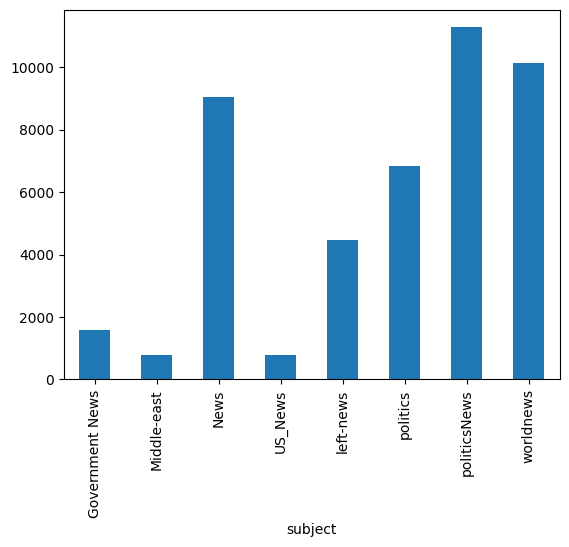

In [24]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


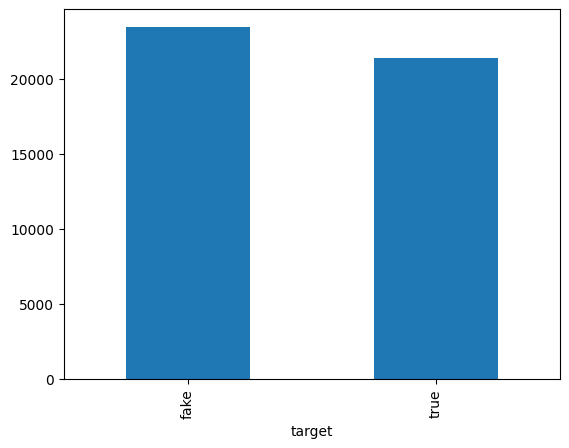

In [25]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

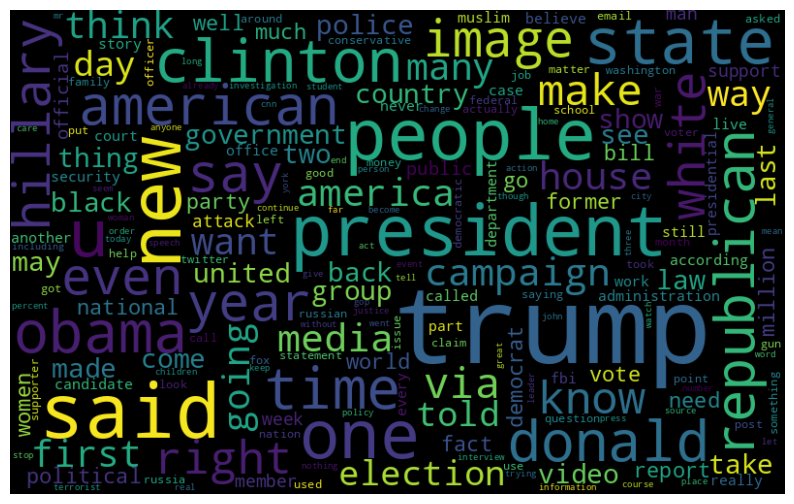

In [26]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

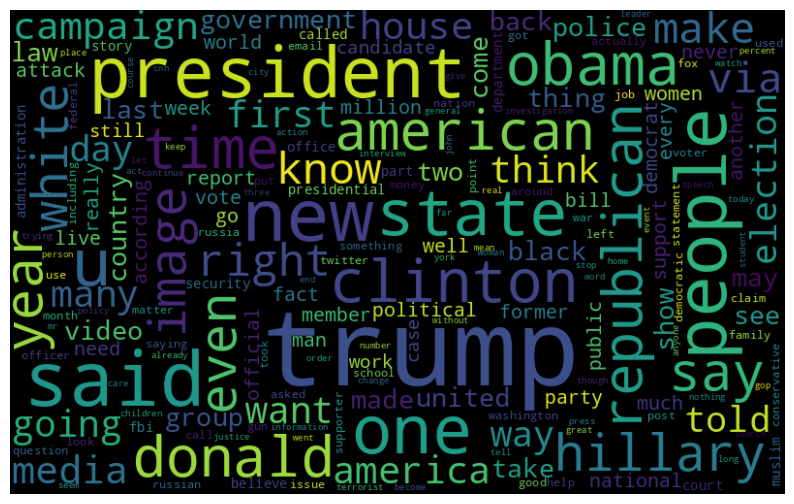

In [27]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [28]:
# Most frequent words counter 
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

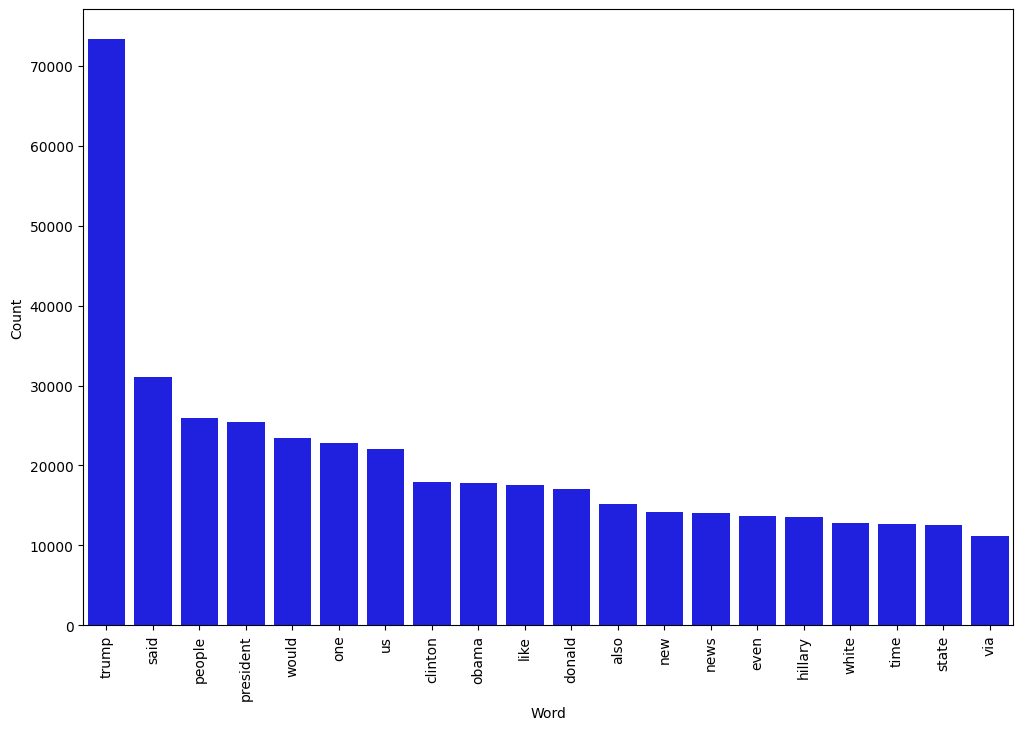

In [29]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

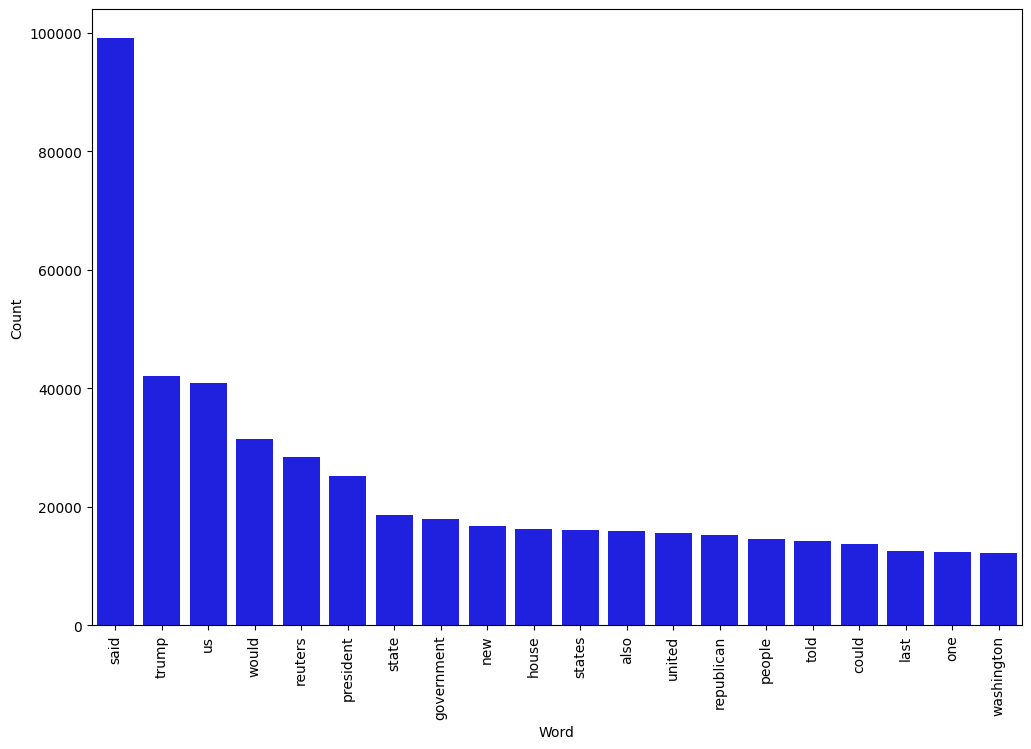

In [30]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [31]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Preparing the Data

In [32]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

In [33]:
# Shape of y_test and x_test
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(35918,) (8980,) (35918,) (8980,)


# **Naive Bayes**




In [34]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model1 = pipe.fit(X_train, y_train)
prediction = model1.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 95.02%


Confusion matrix, without normalization


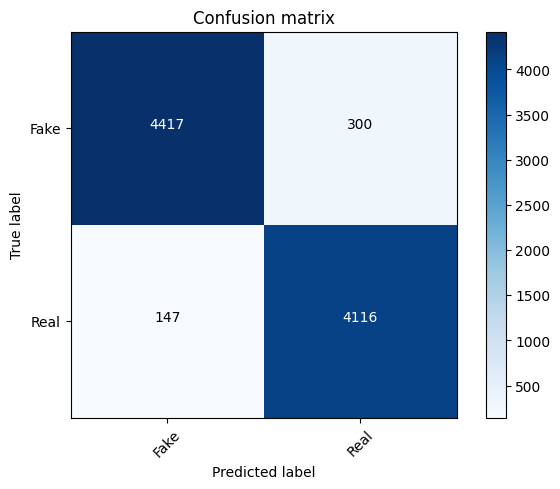

In [35]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### ROC Curve

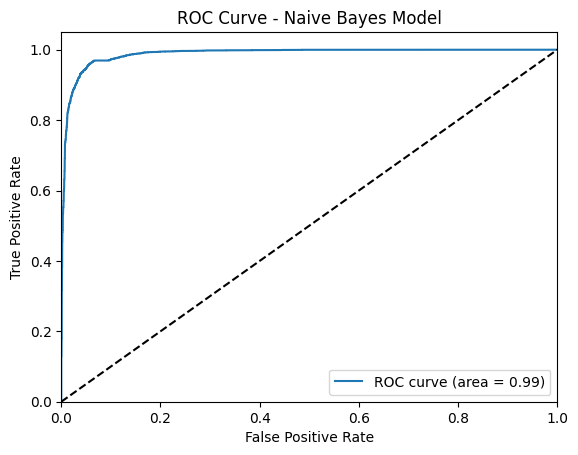

In [36]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities
y_pred_proba = model1.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='true')
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes Model')
plt.legend(loc="lower right")
plt.show()

# **Logistic regression**

In [37]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model2 = pipe.fit(X_train, y_train)

# Accuracy
prediction = model2.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 98.84%


Confusion matrix, without normalization


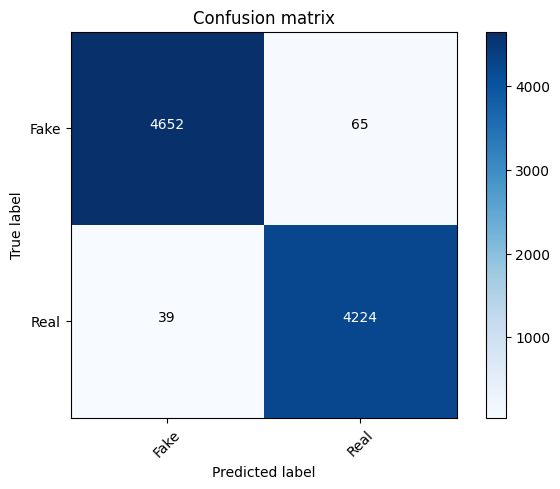

In [38]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### ROC Curve

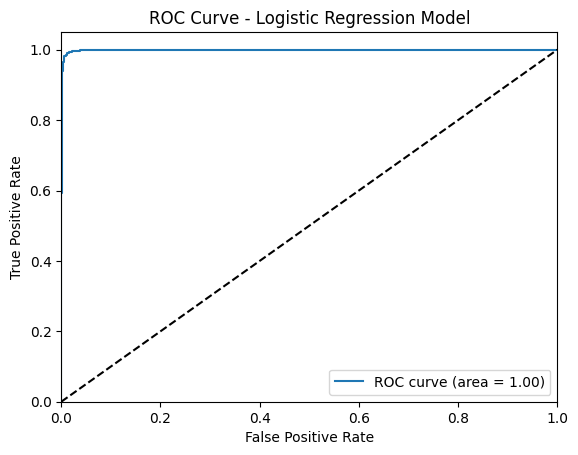

In [39]:
# Get predicted probabilities
y_pred_proba = model2.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='true')
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression Model')
plt.legend(loc="lower right")
plt.show()

# **Decision Tree**

In [40]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model3 = pipe.fit(X_train, y_train)

# Accuracy
prediction = model3.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.64%


Confusion matrix, without normalization


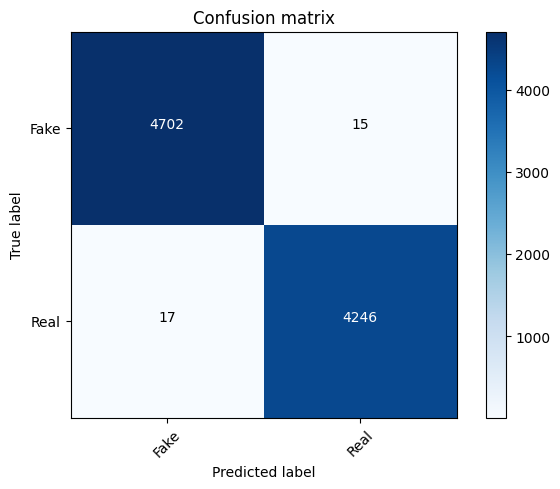

In [41]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### ROC Curve

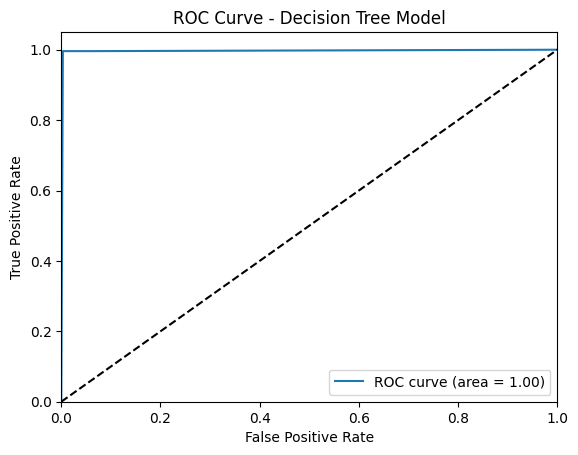

In [42]:
# Get predicted probabilities
y_pred_proba = model3.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='true')
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree Model')
plt.legend(loc="lower right")
plt.show()

# **Random Forest**

In [43]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model4 = pipe.fit(X_train, y_train)
prediction = model4.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 99.21%


Confusion matrix, without normalization


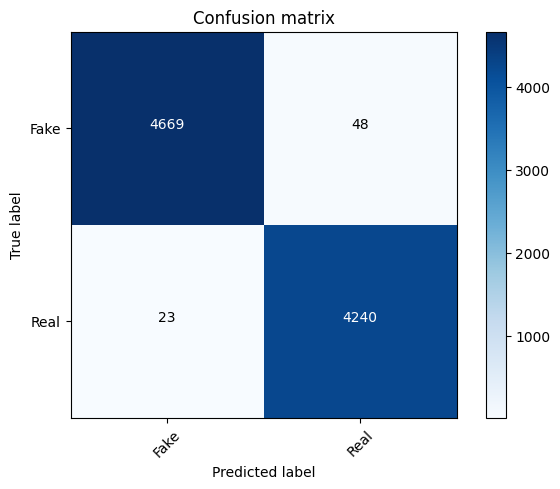

In [44]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### ROC Curve

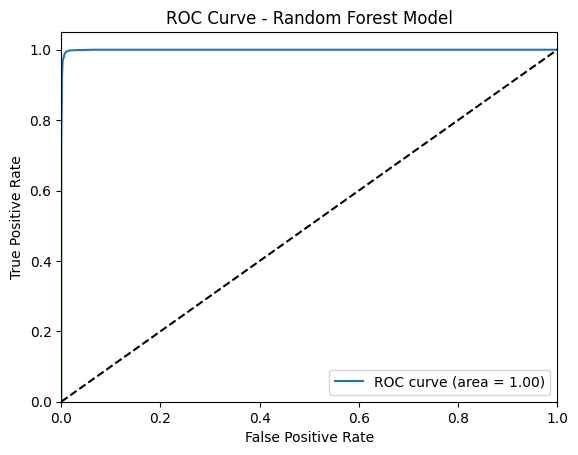

In [45]:
# Get predicted probabilities
y_pred_proba = model4.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='true')
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Model')
plt.legend(loc="lower right")
plt.show()

## **SVM**

In [46]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model5 = pipe.fit(X_train, y_train)
prediction = model5.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)



accuracy: 99.6%


Confusion matrix, without normalization


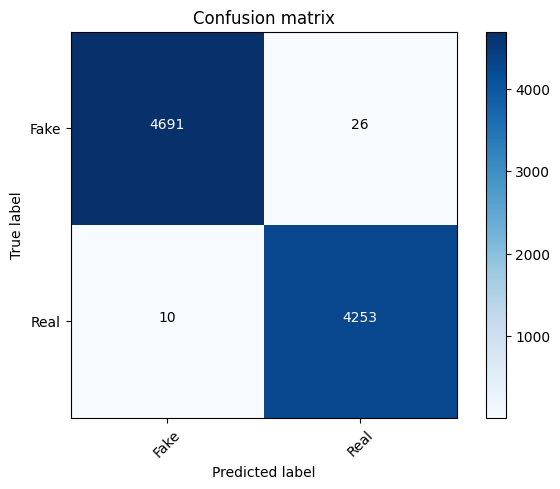

In [47]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### ROC Curve

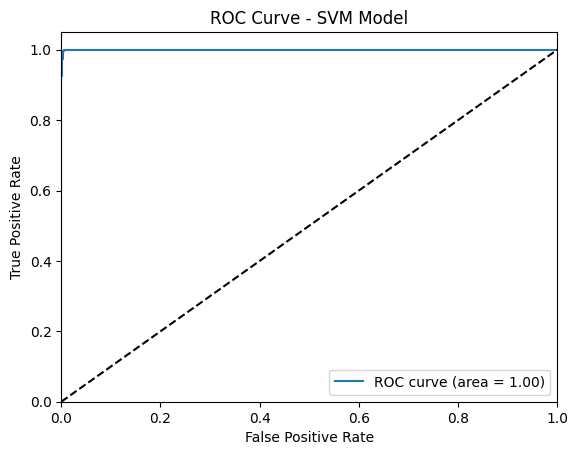

In [48]:
from sklearn.preprocessing import LabelEncoder

# Encode labels as 0 and 1
le = LabelEncoder()
y_test = le.fit_transform(y_test)

# Get predicted probabilities
y_score = model5.decision_function(X_test)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Model')
plt.legend(loc="lower right")
plt.show()


# All models on a single ROC plot

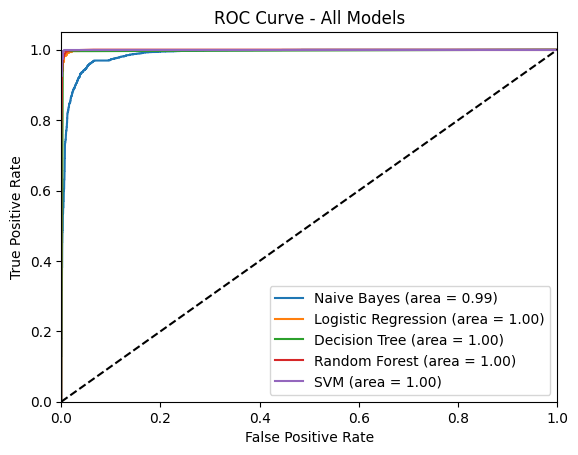

In [49]:
# Get predicted probabilities for each model
y_pred_proba_1 = model1.predict_proba(X_test)[:, 1]
y_pred_proba_2 = model2.predict_proba(X_test)[:, 1]
y_pred_proba_3 = model3.predict_proba(X_test)[:, 1]
y_pred_proba_4 = model4.predict_proba(X_test)[:, 1]
y_score_5 = model5.decision_function(X_test)

# Convert the test labels to int type 
y_test = y_test.astype(int)

# Compute ROC curve and ROC area for each model
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_proba_1, pos_label=1)
roc_auc1 = auc(fpr1, tpr1)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_proba_2, pos_label=1)
roc_auc2 = auc(fpr2, tpr2)
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred_proba_3, pos_label=1)
roc_auc3 = auc(fpr3, tpr3)
fpr4, tpr4, thresholds4 = roc_curve(y_test, y_pred_proba_4, pos_label=1)
roc_auc4 = auc(fpr4, tpr4)
fpr5, tpr5, thresholds5 = roc_curve(y_test, y_score_5)
roc_auc5 = auc(fpr5, tpr5)

# Plot ROC curve for each model on a single plot
plt.plot(fpr1, tpr1, label='Naive Bayes (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='Logistic Regression (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, label='Decision Tree (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, label='Random Forest (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, label='SVM (area = %0.2f)' % roc_auc5)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - All Models')
plt.legend(loc="lower right")
plt.show()

## Random Forest classifier for feature extraction

In [50]:
## Feature Extraction
from sklearn.metrics import confusion_matrix

# Vectorize text data using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['text'])

# Apply TfidfTransformer to the vectorized data
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)

# Create target variable
y = data['target']

## Modeling
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the performance of the classifier
print('Accuracy:', accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=["fake", "true"])
print('Confusion matrix:', cm)

Accuracy: 0.9929844097995546
Confusion matrix: [[4666   51]
 [  12 4251]]


# **Comparing** **Different Models**

Text(0.5, 1.0, 'Model vs Accuracy')

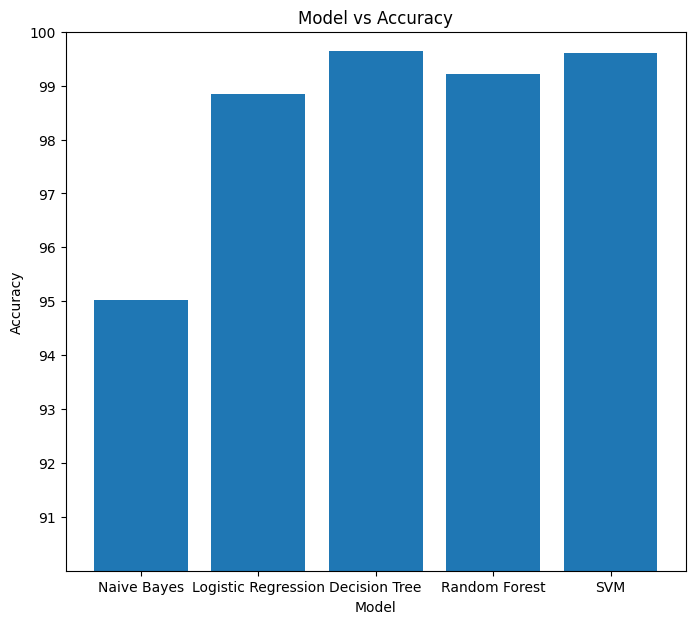

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title('Model vs Accuracy')